In [664]:
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

from tensorflow.keras import layers, losses
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Model
from sklearn.preprocessing import StandardScaler
import seaborn as sns
from matplotlib import rcParams
import keras

import warnings
warnings.filterwarnings('ignore')

In [665]:
def plot_loss_accuracy(history):
    rcParams['figure.figsize'] = 20,3
    fig, ax = plt.subplots(1,2)
    ax[0].plot(history.history['loss'])
    ax[0].plot(history.history['val_loss'])
    ax[0].title.set_text('model loss')
    ax.flat[0].set(ylabel = 'loss',xlabel='epoch')
    ax[0].legend(['train', 'val'], loc='upper right')

    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']
    ax[1].plot(history.history['accuracy'])
    ax[1].plot(history.history['val_accuracy'])
    ax[0].title.set_text('model accuracy')
    ax.flat[1].set(ylabel = 'accuracy',xlabel='epoch')
    ax[1].legend(['train', 'val'], loc='upper left')
    plt.show()

In [666]:
def load_data(path='../data/'):
    df_sensors = pd.read_csv(path + 'PdM_telemetry.csv')
    df_metadata = pd.read_csv(path + 'PdM_machines.csv')
    df_maintenance = pd.read_csv(path + 'PdM_maint.csv')
    df_failures = pd.read_csv(path + 'PdM_failures.csv')
    df_errors = pd.read_csv(path + 'PdM_errors.csv')
    return df_sensors, df_metadata, df_maintenance, df_failures, df_errors

In [667]:
df_sensors, df_metadata, df_maintenance, df_failures, df_errors = load_data()

In [668]:
# Format date & time. Sort based on date for better readability
tables = [df_sensors, df_maintenance, df_failures, df_errors]
for df in tables:
    df["datetime"] = pd.to_datetime(df["datetime"], format="%Y-%m-%d %H:%M:%S")
    df.sort_values(["datetime", "machineID"], inplace=True, ignore_index=True)

In [669]:
base_features = list(df_sensors.drop(['datetime', 'machineID'], axis=1).columns)

In [670]:
# df = df_sensors.merge(df_failures, how='left').merge(df_errors, how='left').merge(df_metadata, how='left').query('machineID <= 20').reset_index(drop=True)
df = df_sensors.merge(df_failures, how='left').merge(df_errors, how='left').merge(df_metadata, how='left').reset_index(drop=True)
df = df.replace('NaN', np.nan)
df['is_error'] = ~((df['errorID'].isnull()))
df['is_anomaly'] = ~((df['failure'].isnull()))
df['model'] = df['model'].str.slice(-1).astype('int')
# df['age'] = df['age'].astype('int')

In [671]:
time_step = 24
def create_sequences(values: list) -> np.array:
    output = []
    for i in range(len(values) - time_step + 1):
        output.append(values[i : (i + time_step)])
    return np.stack(output)

In [672]:
scaler_auto = StandardScaler()
scaler_auto.fit(df.drop(['machineID', 'datetime','failure', 'errorID','is_anomaly','is_error', 'model','age'], axis=1))

StandardScaler()

In [673]:
def transform_values(dataframe, scaler):
    dataframe = dataframe.reset_index(drop=True)
    np_scaled = scaler_auto.transform(dataframe.drop(['machineID', 'datetime','failure', 'errorID','is_anomaly','is_error', 'model','age'], axis=1))
    np_scaled = np.hstack((np_scaled, dataframe['model'].to_numpy().reshape((dataframe['model'].shape[0]),1)))
    # np_scaled = np.hstack((np_scaled, dataframe['age'].to_numpy().reshape((dataframe['age'].shape[0]),1)))
    data = create_sequences(np_scaled)
    labels = dataframe.loc[time_step-1:,'is_anomaly'].astype('int').values
    return data, labels


In [674]:
data_list = []
labels_list = []
for key,data_group in df.groupby('machineID', group_keys=False):
    data, labels = transform_values(data_group, scaler=scaler_auto)
    data_list.append(data)
    labels_list.append(labels)
data = np.concatenate(data_list)
labels = np.concatenate(labels_list)

In [675]:
df.shape

(876445, 12)

In [676]:
print(data.shape)
print(labels.shape)

(874145, 24, 5)
(874145,)


In [677]:
train_data, test_data, train_labels, test_labels = train_test_split(data, labels, test_size = 0.2, random_state = 21)

In [678]:
train_labels = train_labels.astype(bool)
test_labels = test_labels.astype(bool)

#Normal data
# n_train_data = train_data[~train_labels]
# n_test_data = test_data[~test_labels]

# #Abnormal data
# an_train_data = train_data[train_labels]
# an_test_data = test_data[test_labels]

In [679]:
# display(n_test_data)

In [680]:
# Autoencoder using Model API
 
class detector(Model):
  def __init__(self):
    super(detector, self).__init__()
    self.encoder = tf.keras.Sequential([
                                        # layers.Dense(128, activation='relu'),
                                        layers.Dense(64, activation='relu'),
                                        layers.Dense(32, activation='relu'),
                                        layers.Dense(16, activation='relu'),
                                        # layers.Dense(8, activation='relu'),
    ])
    self.decoder = tf.keras.Sequential([
                                        # layers.Dense(16, activation='relu'),
                                        layers.Dense(32, activation='relu'),
                                        layers.Dense(64, activation='relu'),
                                        # layers.Dense(128, activation='relu'),
                                        layers.Dense(data.shape[2], activation='relu'),
    ])

  def call(self, x):
    encoded = self.encoder(x)
    decoded = self.decoder(encoded)
    return decoded

In [681]:
callback = tf.keras.callbacks.EarlyStopping(monitor='loss', patience=5)
keras.utils.set_random_seed(42)
#Compiling Model
autoencoder = detector()
autoencoder.compile(optimizer='adam', loss='mse', metrics=["accuracy"])
history = autoencoder.fit(train_data, train_data, epochs = 60, batch_size=512, validation_data=(test_data, test_data), callbacks=[callback])

Epoch 1/60
1366/1366 ━━━━━━━━━━━━━━━━━━━━ 17s 12ms/step - accuracy: 0.9319 - loss: 0.6562 - val_accuracy: 0.9726 - val_loss: 0.4882
Epoch 2/60
1366/1366 ━━━━━━━━━━━━━━━━━━━━ 16s 12ms/step - accuracy: 0.9728 - loss: 0.4889 - val_accuracy: 0.9739 - val_loss: 0.4882
Epoch 3/60
1366/1366 ━━━━━━━━━━━━━━━━━━━━ 16s 12ms/step - accuracy: 0.9737 - loss: 0.4888 - val_accuracy: 0.9743 - val_loss: 0.4881
Epoch 4/60
1366/1366 ━━━━━━━━━━━━━━━━━━━━ 16s 12ms/step - accuracy: 0.9740 - loss: 0.4888 - val_accuracy: 0.9743 - val_loss: 0.4882
Epoch 5/60
1366/1366 ━━━━━━━━━━━━━━━━━━━━ 15s 11ms/step - accuracy: 0.9742 - loss: 0.4888 - val_accuracy: 0.9747 - val_loss: 0.4881
Epoch 6/60
1366/1366 ━━━━━━━━━━━━━━━━━━━━ 17s 12ms/step - accuracy: 0.9743 - loss: 0.4888 - val_accuracy: 0.9745 - val_loss: 0.4881
Epoch 7/60
1366/1366 ━━━━━━━━━━━━━━━━━━━━ 16s 11ms/step - accuracy: 0.9743 - loss: 0.4888 - val_accuracy: 0.9749 - val_loss: 0.4881
Epoch 8/60
1366/1366 ━━━━━━━━━━━━━━━━━━━━ 15s 11ms/step - accuracy: 0.9745 -

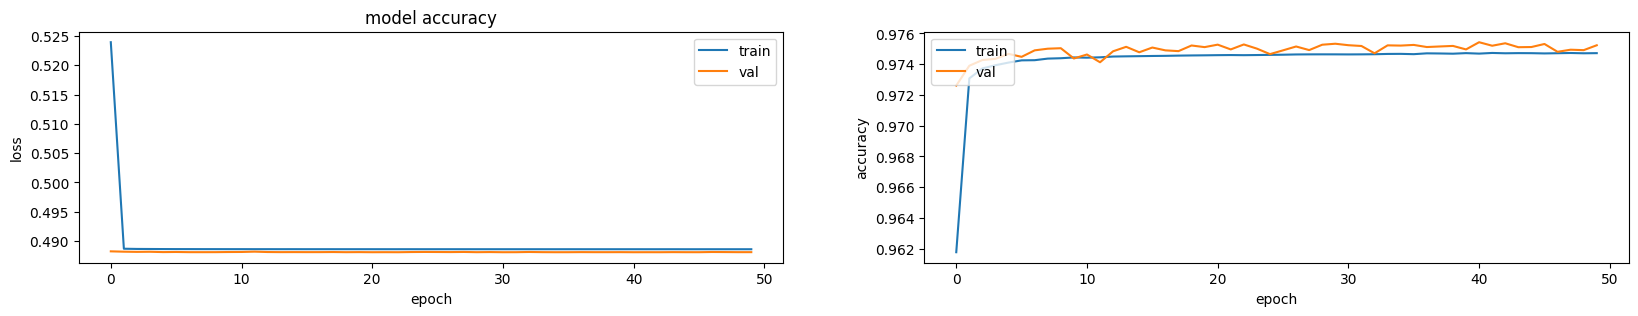

In [682]:
plot_loss_accuracy(history)


In [683]:
def result_autoencoder(model: object, x_train: np.array) -> tf.Tensor:
    # Calculate the reconstruction error for each data point
    reconstructions_deep = model.predict(x_train)
    mse = tf.reduce_mean(tf.square(x_train - reconstructions_deep), axis=[1, 2])
    return mse

In [684]:
mse = result_autoencoder(autoencoder, data)
anomaly_deep_scores = pd.Series(mse.numpy(), name="anomaly_scores")

27318/27318 ━━━━━━━━━━━━━━━━━━━━ 22s 801us/step


<Axes: >

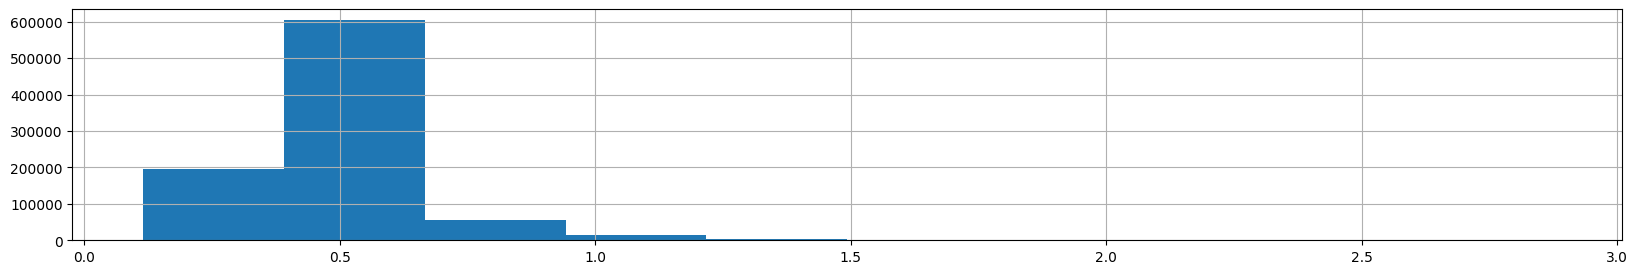

In [685]:
anomaly_deep_scores.hist()

In [686]:
threshold = anomaly_deep_scores.quantile(0.965)

In [687]:
index = 0
total_data = []
for key,data_group in df.groupby('machineID', group_keys=False):
    data_group = data_group.reset_index(drop=True)
    rows = data_group.shape[0]
    data_group.loc[time_step-1:,'anomaly_score'] = anomaly_deep_scores[index:index+rows-time_step+1].to_numpy()
    index+=rows-time_step+1
    data_group['is_anomaly'] = False
    for idx in data_group[~(data_group['failure'].isnull())].index:
        start_idx = max(0, idx - time_step)  # Index error
        data_group.loc[start_idx:idx, 'is_anomaly'] = True
    total_data.append(data_group)
total_data = pd.concat(total_data)

In [688]:
total_data['pred_anomaly'] = False
total_data.loc[total_data['anomaly_score'] > threshold,'pred_anomaly'] = True

In [689]:
def plot_values(df, base_features):
    rcParams['figure.figsize'] = 20,3
    # for feature in base_features:
    feature='vibration'
    sns.lineplot(df, x='datetime', y=feature)
    sns.scatterplot(df[df['pred_anomaly'] == True], x='datetime', y=feature, color='red', label='Prediction', zorder=7)
    # for error_date in df.loc[df['pred_anomaly'] == True, 'datetime']:
    #     plt.axvline(x=error_date, color='orange', linestyle='--', linewidth=1, label='Error')
    for error_date in df.loc[df['is_anomaly'] == True, 'datetime']:
        plt.axvline(x=error_date, color='red', linestyle='--', linewidth=1, label='Error', alpha=0.05)
    for error_date in df.loc[df['is_error'] == True, 'datetime']:
        plt.axvline(x=error_date, color='orange', linestyle='--', linewidth=1, label='Possible Error', alpha=0.5)
    plt.show()

ID: 52


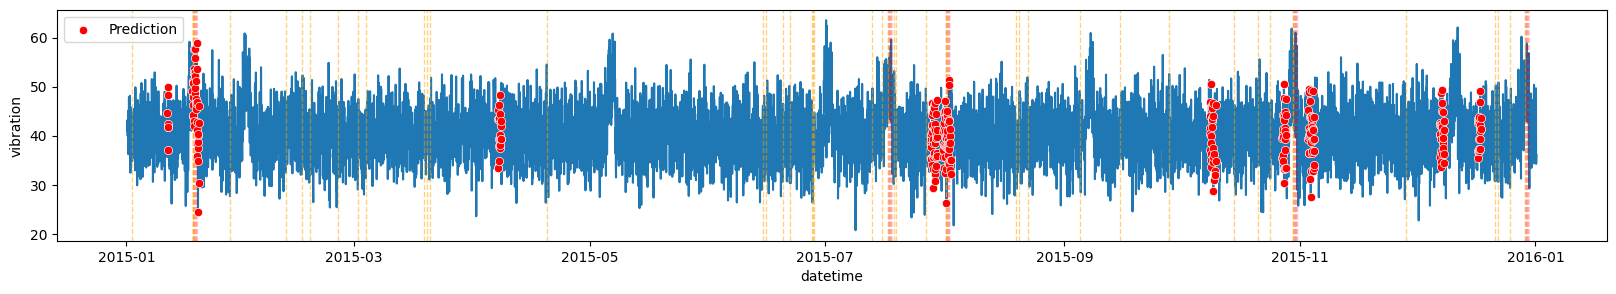

In [690]:
machine_id = np.random.choice(df.machineID.unique())
# machine_id = 10
print('ID:',machine_id)
df_tmp = total_data.query('machineID == @machine_id')
plot_values(df_tmp, base_features=base_features)

In [691]:
from sklearn.metrics import classification_report
print(classification_report(total_data['is_anomaly'], total_data['pred_anomaly']))

              precision    recall  f1-score   support

       False       0.99      0.97      0.98    858501
        True       0.21      0.36      0.27     17944

    accuracy                           0.96    876445
   macro avg       0.60      0.67      0.62    876445
weighted avg       0.97      0.96      0.96    876445



In [692]:
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score


accuracy = accuracy_score(total_data['is_anomaly'], total_data['pred_anomaly'])
print(f'Accuracy: {accuracy:.2f}')
precision = precision_score(total_data['is_anomaly'], total_data['pred_anomaly'])
print(f'Precision: {precision:.2f}')
f1 = f1_score(total_data['is_anomaly'], total_data['pred_anomaly'])
print(f'F1 Score (Balance between false positives and true positives): {f1:.2f}')

recall = recall_score(total_data['is_anomaly'], total_data['pred_anomaly'])
print(f'Recall (How well anomalies are detected - True positives): {recall:.2f}')

Accuracy: 0.96
Precision: 0.21
F1 Score (Balance between false positives and true positives): 0.27
Recall (How well anomalies are detected - True positives): 0.36


In [693]:
total_data['is_real_anomaly'] = ~((total_data['failure'].isnull()))

In [694]:
index = 0
output_data = []
for key,data_group in total_data.groupby('machineID', group_keys=False):
    data_group['is_predicted_anomaly'] = False
    for idx in data_group.query('is_real_anomaly == True').index:
        start_idx = max(0, idx - time_step)  # Index error
        if data_group.loc[start_idx:idx, 'pred_anomaly'].sum() > 0:
            data_group.loc[idx, 'is_predicted_anomaly'] = True
    output_data.append(data_group)
output_data = pd.concat(output_data)

In [695]:
n_real = output_data.is_real_anomaly.sum()
n_predicted = output_data.is_predicted_anomaly.sum()
print('Number of real anomalies:',n_real)
print('Number of anomalies that were detected:',n_predicted)
print('Percentage of detected anomalies:',round(n_predicted*100/n_real, 2))

Number of real anomalies: 761
Number of anomalies that were detected: 414
Percentage of detected anomalies: 54.4
